In [15]:
import numpy as np
import os
import pickle

task_list = [ 'autoencoder','class_1000', 'class_places','curvature', 'edge2d', 'edge3d',\
                         'keypoint2d', 'keypoint3d','reshade', 'rgb2depth', 'rgb2mist', 'rgb2sfnorm','room_layout' , \
                         'segment25d', 'segment2d', 'segmentsemantic','vanishing_point']
list_of_tasks = 'autoencoder curvature denoise edge2d edge3d \
keypoint2d keypoint3d colorization \
reshade rgb2depth rgb2mist rgb2sfnorm \
room_layout segment25d segment2d vanishing_point \
segmentsemantic class_1000 class_places inpainting_whole pascal_voc_segmentation'
task_list_new = list_of_tasks.split(' ')
indices = []
for task in task_list:
    indices.append(task_list_new.index(task))


indices = np.array(indices)
print(indices)

[ 0 17 18  1  3  4  5  6  8  9 10 11 12 13 14 16 15]


In [16]:
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [17]:
path = '/home/kshitid20/Documents/Gemma Roig lab Dropbox/Kshitij/Multitask/CVPR_transferlearning/CVPR2020_results/pascal_normcomparison_pascal_5000'
os.chdir(path)

In [18]:
from scipy.stats import spearmanr,pearsonr

kernel_affinities =  np.load('kernels.npy',allow_pickle=True).item()
rdm_affinities = np.load('rdms.npy',allow_pickle=True).item()

corr_value = {}
performance = [0.590164306133055,0.649290395668602,0.652942936208706,0.647184483742267,0.600769184861427,\
                           0.649696268320798, 0.5994201374950169,0.647529319500711,\
                           0.6300454561362,0.6487250234464327,0.643817731132111,0.647786678981121,0.625850319733945,\
                           0.656534260134841,0.629964850307006,0.648764305659868, 0.589181267604318];

for kernel,kernel_affinity in kernel_affinities.items():
    corr_value[kernel] = {}
    for similarity,similarity_affinity in kernel_affinity.items():
        corr_value[kernel][similarity] = {}
        for ablation,ablation_affinity in similarity_affinity.items():
            corr_value[kernel][similarity][ablation] = {}
            for f_ablation,f_ablation_affinity in ablation_affinity.items():
                corr_value_matrix = np.zeros(f_ablation_affinity.shape[0])
                for iter in range(f_ablation_affinity.shape[0]):
                    #print(f_ablation_affinity.shape)
                    #print(f_ablation_affinity[iter,:])
                    #print(performance)
                    temp,_ = spearmanr(performance, f_ablation_affinity[iter,indices])
                    corr_value_matrix[iter] = temp
                corr_value[kernel][similarity][ablation][f_ablation] = corr_value_matrix
                print(kernel,similarity,ablation,f_ablation)
            

for rdm,rdm_affinity in rdm_affinities.items():
    corr_value[rdm] = {}
    for similarity,similarity_affinity in rdm_affinity.items():
        corr_value[rdm][similarity] = {}
        for ablation,ablation_affinity in similarity_affinity.items():
            corr_value[rdm][similarity][ablation] = {}
            for f_ablation,f_ablation_affinity in ablation_affinity.items():
                corr_value_matrix = np.zeros(f_ablation_affinity.shape[0])
                for iter in range(f_ablation_affinity.shape[0]):
                    print(f_ablation_affinity.shape,f_ablation_affinity[iter,indices])
                    temp,_ = spearmanr(performance, f_ablation_affinity[iter,indices])
                    corr_value_matrix[iter] = temp
                corr_value[rdm][similarity][ablation][f_ablation] = corr_value_matrix
                print(rdm,similarity,ablation,f_ablation)
#print(corr_value)

linear cka debiased_centered znorm
linear cka debiased_centered None
linear cka debiased_centered group_norm
linear cka debiased_centered batch_norm
linear cka debiased_centered instance_norm
linear cka debiased_centered layer_norm
rbf cka debiased_centered znorm
rbf cka debiased_centered None
rbf cka debiased_centered group_norm
rbf cka debiased_centered batch_norm
rbf cka debiased_centered instance_norm
rbf cka debiased_centered layer_norm
lap cka debiased_centered znorm
lap cka debiased_centered None
lap cka debiased_centered group_norm
lap cka debiased_centered batch_norm
lap cka debiased_centered instance_norm
lap cka debiased_centered layer_norm
(100, 21) [0.1220339  0.25670263 0.24609385 0.17673442 0.06729931 0.17869136
 0.09796497 0.21812231 0.22277336 0.18389279 0.24183421 0.18603398
 0.12797973 0.25685694 0.13300179 0.20373624 0.06210274]
(100, 21) [0.14281999 0.33062876 0.28538029 0.25244668 0.10952746 0.26265936
 0.09166109 0.24883169 0.2880459  0.23932123 0.28597258 0.2321

(100, 21) [0.0768189  0.27258286 0.26267472 0.03003089 0.07195142 0.16815596
 0.06397906 0.12158842 0.17918203 0.03294128 0.18410699 0.16000545
 0.12370163 0.21593605 0.09862574 0.15062154 0.00359517]
(100, 21) [0.0909755  0.29969515 0.31946441 0.03194868 0.08328407 0.1701108
 0.09933001 0.12112024 0.19942046 0.03821294 0.20859    0.1876079
 0.13484075 0.2780363  0.15088084 0.17272542 0.00525252]
(100, 21) [0.09826408 0.27521699 0.25686637 0.02482776 0.07262919 0.1667943
 0.11055215 0.10656804 0.18454267 0.036071   0.22448709 0.15141137
 0.13876836 0.22331593 0.15301195 0.13119123 0.06482584]
(100, 21) [0.07991685 0.24894615 0.2401472  0.03261617 0.0680672  0.09117082
 0.065827   0.13144296 0.19901579 0.03745068 0.21206668 0.16723034
 0.1127224  0.20371576 0.12293992 0.15654676 0.00359375]
(100, 21) [0.07089261 0.28814035 0.26004806 0.03280762 0.07212929 0.10863981
 0.06434296 0.13392725 0.22280288 0.06989075 0.229361   0.20247469
 0.12878402 0.22153346 0.10729934 0.19569027 0.01411067

(100, 21) [0.05327305 0.29865104 0.26335143 0.15337531 0.07475295 0.18756855
 0.06267574 0.18029944 0.20427313 0.09518109 0.21162192 0.14533432
 0.14492018 0.23722344 0.10549622 0.18858594 0.08238735]
(100, 21) [0.0873049  0.28939116 0.26773399 0.19151997 0.12018685 0.19496713
 0.0900944  0.20493841 0.23526558 0.06912542 0.24091203 0.1529175
 0.14417176 0.25979356 0.13440706 0.20743446 0.06992608]
(100, 21) [0.05885353 0.27748396 0.28503766 0.22752651 0.11139937 0.22271196
 0.07496501 0.20089036 0.26272095 0.12372508 0.27042499 0.19388867
 0.1734154  0.24448625 0.11844107 0.2052226  0.07786252]
(100, 21) [0.10224497 0.30485799 0.31041794 0.21754023 0.08467716 0.19177144
 0.09967735 0.19846219 0.25553794 0.11562792 0.25826032 0.17067779
 0.15688383 0.22558693 0.1441913  0.17938902 0.06504691]
(100, 21) [0.05409822 0.29470559 0.25011802 0.21999969 0.11956554 0.21615969
 0.0654102  0.20894561 0.24937441 0.11958737 0.24837239 0.19290304
 0.16065846 0.27457543 0.12469057 0.20482163 0.099685

 0.05118916 0.1960509  0.11464851 0.13243159 0.03420415]
(100, 21) [0.07552875 0.19331482 0.17210573 0.17463497 0.07508627 0.14118431
 0.06752804 0.17596732 0.16087656 0.09324435 0.18417549 0.13485468
 0.06772017 0.18738636 0.09884324 0.14225958 0.06084098]
(100, 21) [0.0487846  0.22111531 0.16586282 0.11424557 0.06885789 0.15777833
 0.05043058 0.15773632 0.14826804 0.10101936 0.16236968 0.12995205
 0.05277163 0.17104306 0.0834548  0.12877788 0.04663498]
(100, 21) [0.06561423 0.20908997 0.1670345  0.15391076 0.11919239 0.1584476
 0.06502598 0.16299829 0.18028989 0.0833994  0.18832299 0.13327916
 0.06009356 0.19101573 0.09446277 0.14600874 0.0301261 ]
(100, 21) [0.07023899 0.19908385 0.19082495 0.19881138 0.11961587 0.19523935
 0.07409315 0.19547622 0.20847488 0.13609802 0.21741262 0.17761034
 0.10209016 0.20493769 0.0946693  0.16265291 0.03210079]
(100, 21) [0.08160158 0.20229522 0.19154715 0.17044898 0.07740865 0.15037427
 0.07335108 0.1565714  0.17911646 0.11417308 0.19387447 0.16576

(100, 21) [0.13557131 0.26999931 0.25668412 0.31103878 0.11577578 0.23540396
 0.09136163 0.25560281 0.26057437 0.23801019 0.25964933 0.22864126
 0.1585674  0.26685092 0.16133393 0.20991829 0.10833564]
(100, 21) [0.14648279 0.2860023  0.25978236 0.33696016 0.10666505 0.28017
 0.11858949 0.26766663 0.25277123 0.18755107 0.27671253 0.23526375
 0.14374717 0.30420886 0.17554262 0.26169149 0.08082901]
(100, 21) [0.14801267 0.28637568 0.26294826 0.29818453 0.09529761 0.21574252
 0.09463735 0.23577023 0.24512176 0.20687833 0.24798508 0.18396213
 0.13242804 0.2900018  0.15580361 0.20106519 0.08046341]
(100, 21) [0.11757365 0.30757706 0.28545337 0.27734891 0.07420632 0.22090713
 0.10065942 0.22249787 0.23417514 0.21914283 0.23781032 0.18442435
 0.15359629 0.27429578 0.13616588 0.23087421 0.07547666]
(100, 21) [0.14017404 0.31545508 0.27427625 0.29875297 0.10403846 0.25989749
 0.09849819 0.28710172 0.30668454 0.24745463 0.30172981 0.24927234
 0.15326943 0.2772621  0.15354413 0.21848857 0.07031247

(100, 21) [0.11272775 0.31675878 0.30377478 0.18789579 0.09731643 0.1948812
 0.1174585  0.21121378 0.24100269 0.10166824 0.24266041 0.15517544
 0.19816783 0.27195    0.16781119 0.19589238 0.04888216]
(100, 21) [0.09147218 0.29801538 0.26155689 0.17696663 0.10180619 0.20726827
 0.09027201 0.22660438 0.24569159 0.12118596 0.2390579  0.16539429
 0.16841614 0.23968824 0.13467633 0.21278549 0.07244885]
(100, 21) [0.103375   0.26676211 0.24456483 0.17815942 0.08327305 0.1729069
 0.10751732 0.19950679 0.20365052 0.10071584 0.2118923  0.17399362
 0.15009063 0.18861734 0.11951887 0.17487264 0.06741206]
(100, 21) [0.116231   0.2953383  0.26349395 0.21954409 0.13275511 0.18384904
 0.12819815 0.23776077 0.25264321 0.08712036 0.26400555 0.17781253
 0.16381273 0.24861719 0.15866184 0.20081864 0.03520671]
(100, 21) [0.10286597 0.29616031 0.26563238 0.19177116 0.11823189 0.21520904
 0.11123836 0.22357624 0.24282788 0.09198058 0.23282281 0.22910266
 0.20728681 0.23582032 0.144296   0.21730953 0.1005205

(100, 21) [0.06679022 0.18091612 0.14392204 0.17768307 0.08913002 0.13874426
 0.05756414 0.15891055 0.15516318 0.11865328 0.17795398 0.1152951
 0.07045135 0.14872025 0.09033556 0.1503193  0.02434298]
(100, 21) [0.05740725 0.15931986 0.12397145 0.15533104 0.09617884 0.12106481
 0.05415631 0.15086173 0.17628638 0.10251649 0.15853277 0.1234624
 0.06110822 0.14441849 0.08892711 0.11855492 0.03905522]
(100, 21) [0.06710459 0.22951958 0.20131598 0.18205899 0.09905752 0.18828104
 0.07588387 0.17993424 0.17441053 0.11201495 0.21855167 0.18717704
 0.07803862 0.19616002 0.10288516 0.14106656 0.05446564]
(100, 21) [0.06752949 0.19401814 0.18033343 0.1477942  0.08360763 0.14807063
 0.07044902 0.16689765 0.15953526 0.10843245 0.15528756 0.14619862
 0.08773793 0.16034457 0.09331941 0.15730039 0.03039235]
(100, 21) [0.04758745 0.18853494 0.15682298 0.14096109 0.07758126 0.13970688
 0.04889023 0.15291341 0.14549326 0.11701298 0.15723115 0.12009937
 0.06897835 0.14198318 0.07647409 0.10808425 0.0532658

(100, 21) [0.11603552 0.30414136 0.28825187 0.25300524 0.12517696 0.2281083
 0.10891953 0.2324719  0.27691725 0.23617393 0.30015073 0.20342351
 0.15395914 0.24466356 0.1749149  0.18955277 0.08183621]
(100, 21) [0.12493441 0.31415888 0.29218508 0.27766718 0.12693422 0.2410451
 0.10546161 0.27456176 0.28097202 0.2365754  0.28230537 0.24415035
 0.16491307 0.2861903  0.17035207 0.21422716 0.09545195]
(100, 21) [0.11646666 0.31002558 0.29711134 0.27136592 0.10129309 0.21222866
 0.09053022 0.24303139 0.25560888 0.21118408 0.2640895  0.19549974
 0.16494101 0.28561228 0.15204416 0.19135958 0.13888662]
(100, 21) [0.1578526  0.32878602 0.3076665  0.33759069 0.13369889 0.27224945
 0.12908361 0.29189641 0.33477627 0.26265359 0.34781351 0.26570013
 0.21654534 0.35213305 0.21430538 0.23205232 0.12384932]
(100, 21) [0.20558851 0.31526867 0.32994019 0.31595629 0.12692533 0.2526802
 0.18109787 0.32260868 0.30010201 0.21319014 0.32333542 0.23792813
 0.1624808  0.30989379 0.2244518  0.22164135 0.08052827

(100, 21) [0.08218094 0.30710452 0.27419261 0.2342001  0.12180036 0.22371064
 0.06337432 0.20910209 0.26203948 0.1707618  0.28367409 0.21075564
 0.17436738 0.26680985 0.14154179 0.20237423 0.06258715]
(100, 21) [0.09190548 0.29999491 0.25052016 0.23257971 0.10634792 0.22073067
 0.08648147 0.2140473  0.20662031 0.08013682 0.26343313 0.21537008
 0.15731415 0.2744437  0.15063716 0.22497723 0.06624783]
(100, 21) [0.12270502 0.33482967 0.30103851 0.19288205 0.1093589  0.18021899
 0.09364834 0.20429276 0.24266776 0.1176518  0.25999602 0.17028433
 0.15491722 0.26646423 0.15751066 0.18869346 0.08328415]
(100, 21) [0.07289343 0.33527807 0.30317379 0.1712252  0.07902332 0.16582206
 0.07626387 0.15089589 0.21298393 0.14099207 0.22208212 0.17565626
 0.1664117  0.2332662  0.12921003 0.20948245 0.07898612]
(100, 21) [0.08071719 0.33080213 0.28589169 0.22215801 0.09715913 0.23670186
 0.07652972 0.22425225 0.27839707 0.13196852 0.29705938 0.22282804
 0.16090301 0.25707617 0.11932518 0.1919976  0.05027

(100, 21) [0.13449944 0.32355534 0.29326324 0.172702   0.12375803 0.23397471
 0.14376501 0.29315898 0.28827097 0.1648049  0.29838502 0.23038951
 0.14760792 0.29959129 0.18329093 0.22379616 0.08236116]
(100, 21) [0.14996384 0.2996503  0.26208515 0.17760713 0.10646111 0.19113936
 0.12844854 0.23598808 0.23338041 0.14166921 0.25153917 0.20552711
 0.15329972 0.24711528 0.1648404  0.1849092  0.07278988]
(100, 21) [0.18090956 0.32728244 0.31908481 0.21793986 0.12534354 0.25084263
 0.16921979 0.289042   0.30761287 0.16961445 0.3460578  0.24268787
 0.13472594 0.30865026 0.22036414 0.19565682 0.10158785]
(100, 21) [0.129495   0.33939874 0.30854949 0.1320618  0.10131225 0.23578913
 0.11341107 0.28256406 0.24962733 0.15089528 0.28608505 0.1815212
 0.16144001 0.27977973 0.16824566 0.19533113 0.08045825]
(100, 21) [0.18540896 0.35799056 0.32618563 0.1726865  0.13068077 0.24561194
 0.14956969 0.26228219 0.26486742 0.18299781 0.29532658 0.23004228
 0.16094041 0.27364983 0.19122081 0.2094444  0.082548

(100, 21) [0.10447906 0.31013548 0.25888788 0.24330055 0.12919634 0.18253255
 0.07945104 0.21900905 0.23230614 0.09027863 0.24846947 0.19428842
 0.17592294 0.26247676 0.14957973 0.16206195 0.04594622]
(100, 21) [0.08409359 0.28856564 0.2809523  0.23426258 0.11677396 0.22360589
 0.08439183 0.20725239 0.26130977 0.13611217 0.28227224 0.21199655
 0.19439801 0.23891553 0.13244963 0.21749718 0.06821751]
(100, 21) [0.09510242 0.34718405 0.29964265 0.27201717 0.15009994 0.24849402
 0.09136868 0.2526022  0.27249038 0.15345939 0.27963138 0.24981795
 0.16701488 0.31330049 0.15155232 0.21048001 0.0818092 ]
(100, 21) [0.10065104 0.29744638 0.2871945  0.218919   0.08616294 0.18710269
 0.10261015 0.17363436 0.2184824  0.11825684 0.27830234 0.18619184
 0.15186626 0.22509176 0.15042744 0.20861374 0.0591403 ]
(100, 21) [0.07978925 0.3138533  0.26334741 0.19626423 0.12508691 0.22186755
 0.08361161 0.21861467 0.25699306 0.12071194 0.27259871 0.18238987
 0.16039895 0.27576544 0.14545819 0.19299891 0.05551

In [19]:
max_corr = 0
for dist,corr_dist in corr_value.items():
    print("------------------------------------------------------------------")
    if True:#dist == 'lap' or dist == 'euclidean':
        for similarity,corr_similarity in corr_dist.items():
            for ablation,corr_ablation in corr_similarity.items():
                if ablation == 'centered' :#or ablation == 'default' :
                    continue
                for f_ablation,corr_f_ablation in corr_ablation.items():
                    #if f_ablation == 'centering':
                    #    continue
                    
                    if np.mean(corr_f_ablation) > max_corr:
                        max_corr = np.mean(corr_f_ablation)
                        max_combo = [dist,similarity,ablation,f_ablation]
                    print(similarity,dist,ablation,f_ablation,np.mean(corr_f_ablation),np.std(corr_f_ablation))
        print("------------------------------------------------------------------")
    else:
            continue
print(max_corr,max_combo)


------------------------------------------------------------------
cka linear debiased_centered znorm 0.7182843137254902 0.06299336224590212
cka linear debiased_centered None 0.5412254901960785 0.08934513072181706
cka linear debiased_centered group_norm 0.6967401960784314 0.045950300314583206
cka linear debiased_centered batch_norm 0.5765686274509805 0.0839059908576676
cka linear debiased_centered instance_norm 0.6749754901960786 0.06884235870994647
cka linear debiased_centered layer_norm 0.7164215686274512 0.043282537214004234
------------------------------------------------------------------
------------------------------------------------------------------
cka rbf debiased_centered znorm 0.7535784313725493 0.051035062127136155
cka rbf debiased_centered None 0.7171568627450982 0.04644591675692282
cka rbf debiased_centered group_norm 0.6662745098039217 0.044684162250364694
cka rbf debiased_centered batch_norm 0.7445098039215686 0.05828400451772398
cka rbf debiased_centered instance_no

In [13]:
from scipy import stats
p_values =  {}
for similarity1,corr_similarity1 in corr_value.items():
    p_values[similarity1] = {}
    for similarity2,corr_similarity2 in corr_value.items():
        distribution_1 = corr_similarity1['cka']['debiased_centered']['znorm']
        distribution_2 = corr_similarity2['cka']['debiased_centered']['znorm']
        _,p_values[similarity1][similarity2] = stats.ttest_ind(distribution_1,distribution_2)

In [14]:
print(p_values)

{'rbf': {'rbf': 1.0, 'lap': 0.06550160264425188, 'cosine': 2.3483639233656505e-05, 'euclidean': 0.34246253650867775, 'pearson': 0.0002007647306877554}, 'lap': {'rbf': 0.06550160264425188, 'lap': 1.0, 'cosine': 1.2380787892288465e-10, 'euclidean': 0.003857598455067651, 'pearson': 3.393354942063742e-09}, 'cosine': {'rbf': 2.3483639233656505e-05, 'lap': 1.2380787892288465e-10, 'cosine': 1.0, 'euclidean': 0.000927326866708376, 'pearson': 0.5739073995207655}, 'euclidean': {'rbf': 0.34246253650867775, 'lap': 0.003857598455067651, 'cosine': 0.000927326866708376, 'euclidean': 1.0, 'pearson': 0.005335268555874873}, 'pearson': {'rbf': 0.0002007647306877554, 'lap': 3.393354942063742e-09, 'cosine': 0.5739073995207655, 'euclidean': 0.005335268555874873, 'pearson': 1.0}}


In [8]:
from scipy.stats import spearmanr,pearsonr

kernel_affinities =  np.load('kernels.npy',allow_pickle=True).item()
rdm_affinities = np.load('rdms.npy',allow_pickle=True).item()

corr_value = {}
for kernel,kernel_affinity in kernel_affinities.items():
    corr_value[kernel] = {}
    for similarity,similarity_affinity in kernel_affinity.items():
        corr_value[kernel][similarity] = {}
        for ablation,ablation_affinity in similarity_affinity.items():
            corr_value[kernel][similarity][ablation] = {}
            for f_ablation,f_ablation_affinity in ablation_affinity.items():
                corr_value_matrix = np.zeros(len(task_list))
                for iter in range(f_ablation_affinity.shape[0]):
                    print(f_ablation_affinity.shape)
                    temp_affinity = np.delete(f_ablation_affinity[iter,:,:], (7, 18,19), axis=0)
                    temp_affinity = np.delete(temp_affinity, (7, 18,19), axis=1)
                    print(temp_affinity.shape)
                    print(len(task_list))
                    for j,task in enumerate(task_list):
                        temp,_ = spearmanr(t_affinity_matrix[:,j], temp_affinity[:,j])
                        corr_value_matrix[j] += temp
                corr_value[kernel][similarity][ablation][f_ablation] = corr_value_matrix/f_ablation_affinity.shape[0]
            

for rdm,rdm_affinity in rdm_affinities.items():
    corr_value[rdm] = {}
    for similarity,similarity_affinity in rdm_affinity.items():
        corr_value[rdm][similarity] = {}
        for ablation,ablation_affinity in similarity_affinity.items():
            corr_value[rdm][similarity][ablation] = {}
            for f_ablation,f_ablation_affinity in ablation_affinity.items():
                corr_value_matrix = np.zeros(len(task_list))
                for iter in range(f_ablation_affinity.shape[0]):
                    temp_affinity = np.delete(f_ablation_affinity[iter,:,:], (7, 18,19), axis=0)
                    temp_affinity = np.delete(temp_affinity, (7, 18,19), axis=1)
                    for j,task in enumerate(task_list):
                        temp,_ = spearmanr(t_affinity_matrix[:,j], temp_affinity[:,j])
                        corr_value_matrix[j] += temp
                corr_value[rdm][similarity][ablation][f_ablation] = corr_value_matrix/f_ablation_affinity.shape[0]
print(corr_value)

(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17, 17)
17
(1, 20, 20)
(17,

In [10]:
max_corr = 0
for dist,corr_dist in corr_value.items():
    print("------------------------------------------------------------------")
    if True:#dist == 'lap' or dist == 'euclidean':
        for similarity,corr_similarity in corr_dist.items():
            for ablation,corr_ablation in corr_similarity.items():
                if ablation == 'centered':
                    continue
                for f_ablation,corr_f_ablation in corr_ablation.items():
                    #if f_ablation == 'centering':
                    #    continue
                    
                    if np.mean(corr_f_ablation) > max_corr:
                        max_corr = np.mean(corr_f_ablation)
                        max_combo = [dist,similarity,ablation,f_ablation]
                    print(similarity,dist,ablation,f_ablation,np.mean(corr_f_ablation))
        print("------------------------------------------------------------------")
    else:
            continue
print(max_corr,max_combo)


------------------------------------------------------------------
cka lap debiased_centered znorm 0.8600057670126875
cka lap debiased_centered None 0.8192041522491349
cka lap debiased_centered layer_norm 0.8147347174163785
cka lap debiased_centered instance_norm 0.8385236447520185
cka lap debiased_centered batch_norm 0.8543829296424453
cka lap debiased_centered centering 0.8192041522491349
cka lap debiased_centered group_norm 0.8213667820069205
cka lap default znorm 0.6943483275663207
cka lap default None 0.533881199538639
cka lap default layer_norm 0.5347462514417533
cka lap default instance_norm 0.6578719723183392
cka lap default batch_norm 0.6421568627450981
cka lap default centering 0.533881199538639
cka lap default group_norm 0.5850634371395618
spearman lap debiased_centered znorm 0.8654844290657441
spearman lap debiased_centered None 0.8331891580161477
spearman lap debiased_centered layer_norm 0.8254036908881202
spearman lap debiased_centered instance_norm 0.8470299884659748
spe

In [46]:
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

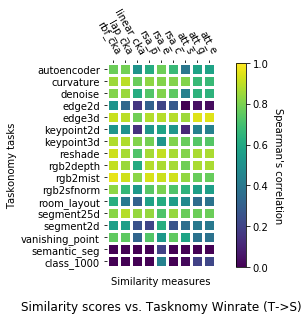

[0.67272203 0.62990196 0.47001153 0.59155133 0.66147636 0.59933679
 0.50346021 0.52133795 0.5233564 ]


In [53]:
#per row correlation
corr_value_row = {}
corr_value_row['rbf_cka'] = {}
corr_value_row['lap_cka'] = {}
corr_value_row['linear_cka'] = {}
corr_value_row['rsa_p'] = {}
corr_value_row['rsa_e'] = {}
corr_value_row['rsa_c'] = {}
corr_value_row['att_s'] = {}
corr_value_row['att_g'] = {}
corr_value_row['att_e'] = {}
corr_value_row_matrix = np.zeros((17,9))
#plt.rcParams.update({'font.size': 12})

for i,task in enumerate(task_list):
    temp,_ = spearmanr(matrix[i,:], affinity_rbf_cka[i,:])
    corr_value_row['rbf_cka'][task]=temp
    corr_value_row_matrix[i,0] = temp

    temp,_ = spearmanr(matrix[i,:], affinity_lap_cka[i,:])
    corr_value_row['lap_cka'][task]=temp
    corr_value_row_matrix[i,1] = temp
    
    temp,_ = spearmanr(matrix[i,:], affinity_linear_cka[i,:])
    corr_value_row['linear_cka'][task]=temp
    corr_value_row_matrix[i,2] = temp
    
    temp,_ = spearmanr(matrix[i,:], affinity_rsa_p[i,:])
    corr_value_row['rsa_p'][task]=temp
    corr_value_row_matrix[i,3] = temp 
    
    temp,_ = spearmanr(matrix[i,:], affinity_rsa_e[i,:])
    corr_value_row['rsa_e'][task]=temp
    corr_value_row_matrix[i,4] = temp
    
    temp,_ = spearmanr(matrix[i,:], affinity_rsa_m[i,:])
    corr_value_row['rsa_c'][task]=temp
    corr_value_row_matrix[i,5] = temp
    
    temp,_ = spearmanr(matrix[i,:], affinity_att_s[i,:])
    corr_value_row['att_s'][task]=temp
    corr_value_row_matrix[i,6] = temp    
    
    temp,_ = spearmanr(matrix[i,:], affinity_att_g[i,:])
    corr_value_row['att_g'][task]=temp
    corr_value_row_matrix[i,7] = temp    
    
    temp,_ = spearmanr(matrix[i,:], affinity_att_e[i,:])
    corr_value_row['att_e'][task]=temp
    corr_value_row_matrix[i,8] = temp
    
fig, ax = plt.subplots()
col_labels = ['rbf_cka','lap_cka','linear_cka','rsa_p','rsa_e','rsa_c','att_s','att_g','att_e']  
row_labels = task_list_refined
im, cbar = heatmap(corr_value_row_matrix, row_labels, col_labels, ax=ax,
            cbar_kw={}, cbarlabel="Spearman's correlation",vmin=0, vmax=1)


fig.tight_layout()
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
plt.ylabel('Taskonomy tasks')
plt.xlabel('Similarity measures')
plt.title("Similarity scores vs. Tasknomy Winrate (T->S)", y=-0.24)

plt.show()

print(np.mean(corr_value_row_matrix,axis=0))




NameError: name 'x_labels' is not defined

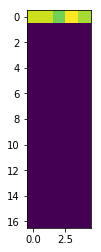

In [13]:
fig, ax = plt.subplots()
ax.imshow(corr_value_row_matrix)
num_x_labels = 5 # how many labels to see on axis x
step_x = int(5 / (num_x_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,5,step_x) # pixel count at label position
 # labels you want to see
plt.xticks(x_positions, x_labels)
plt.xticks(rotation=80)

num_y_labels = 17 # how many labels to see on axis x
step_y = int(17 / (num_y_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,17,step_y) # pixel count at label position
y_labels = task_list # labels you want to see
plt.yticks(y_positions, y_labels)
plt.colorbar()
print(np.mean(corr_value_row_matrix,axis=0))

for (j,i),label in np.ndenumerate(corr_value_row_matrix):
    ax.text(i,j,label,ha='center',va='center')

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

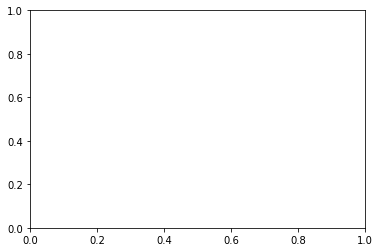

In [9]:
import matplotlib.pyplot as plt

D=corr_value_row
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.xticks(rotation=70)
plt.ylabel('Pearsons Correlation')
plt.xlabel('Similiarity measures')
plt.title("Correlation with Taskonomy matrix")
plt.show()

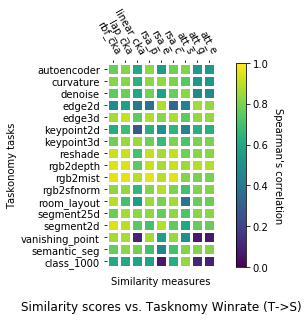

[0.67272203 0.62990196 0.47001153 0.59155133 0.66147636 0.59933679
 0.50346021 0.52133795 0.5233564 ]
[0.80017301 0.81502307 0.63249712 0.78056517 0.70141292 0.77825836
 0.69031142 0.66868512 0.66681084]


In [52]:
#per column correlation 
#per row correlation
corr_value_col = {}
corr_value_col['rbf_cka'] = {}
corr_value_col['lap_cka'] = {}
corr_value_col['linear_cka'] = {}
corr_value_col['rsa_p'] = {}
corr_value_col['rsa_e'] = {}
corr_value_col['rsa_c'] = {}
corr_value_col['att_s'] = {}
corr_value_col['att_g'] = {}
corr_value_col['att_e'] = {}
corr_value_col_matrix = np.zeros((17,9))
for j,task in enumerate(task_list):
    temp,_ = spearmanr(matrix[:,j], affinity_rbf_cka[:,j])
    corr_value_col['rbf_cka'][task]=temp
    corr_value_col_matrix[j,0] = temp

    temp,_ = spearmanr(matrix[:,j], affinity_lap_cka[:,j])
    corr_value_col['lap_cka'][task]=temp
    corr_value_col_matrix[j,1] = temp    
    
    temp,_ = spearmanr(matrix[:,j], affinity_linear_cka[:,j])
    corr_value_col['linear_cka'][task]=temp
    corr_value_col_matrix[j,2] = temp
    
    temp,_ = spearmanr(matrix[:,j], affinity_rsa_p[:,j])
    corr_value_col['rsa_p'][task]=temp
    corr_value_col_matrix[j,3] = temp   
    
    temp,_ = spearmanr(matrix[:,j], affinity_rsa_e[:,j])
    corr_value_col['rsa_e'][task]=temp
    corr_value_col_matrix[j,4] = temp
    
    temp,_ = spearmanr(matrix[:,j], affinity_rsa_m[:,j])
    corr_value_col['rsa_c'][task]=temp
    corr_value_col_matrix[j,5] = temp
    

    
    temp,_ = spearmanr(matrix[:,j], affinity_att_s[:,j])
    corr_value_col['att_s'][task]=temp
    corr_value_col_matrix[j,6] = temp    
    temp,_ = spearmanr(matrix[:,j], affinity_att_g[:,j])
    corr_value_col['att_g'][task]=temp
    corr_value_col_matrix[j,7] = temp    
    temp,_ = spearmanr(matrix[:,j], affinity_att_e[:,j])
    corr_value_col['att_e'][task]=temp
    corr_value_col_matrix[j,8] = temp
    
fig, ax = plt.subplots()
col_labels = ['rbf_cka','lap_cka','linear_cka','rsa_p','rsa_e','rsa_c','att_s','att_g','att_e']    
row_labels = task_list_refined
im, cbar = heatmap(corr_value_col_matrix, row_labels, col_labels, ax=ax,
            cbar_kw={}, cbarlabel="Spearman's correlation",vmin=0, vmax=1)

fig.tight_layout()
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
plt.ylabel('Taskonomy tasks')
plt.xlabel('Similarity measures')
plt.title("Similarity scores vs. Tasknomy Winrate (T->S)", y=-0.24)

plt.show()
print(np.mean(corr_value_row_matrix,axis=0))


print(np.mean(corr_value_col_matrix,axis=0))

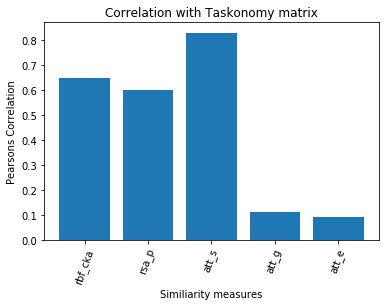

In [14]:
import matplotlib.pyplot as plt

D=corr_value_col
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.xticks(rotation=70)
plt.ylabel('Pearsons Correlation')
plt.xlabel('Similiarity measures')
plt.title("Correlation with Taskonomy matrix")
plt.show()